In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
file_path = "clean_data.csv"  
df = pd.read_csv(file_path)
df

,user_number,datetime,Consommation
0,1,01/03/2016 01:19:43,0
1,1,01/03/2016 02:19:43,0
2,1,01/03/2016 03:19:43,0
3,1,01/03/2016 04:19:43,0
4,1,01/03/2016 05:39:54,0
...,...,...,...
673922,92,28/02/2017 18:08:01,0
673923,92,28/02/2017 19:08:06,0
673924,92,28/02/2017 20:08:06,27
673925,92,28/02/2017 21:08:06,43


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)
df

,user_number,datetime,Consommation
0,1,2016-03-01 01:19:43,0
1,1,2016-03-01 02:19:43,0
2,1,2016-03-01 03:19:43,0
3,1,2016-03-01 04:19:43,0
4,1,2016-03-01 05:39:54,0
...,...,...,...
673922,92,2017-02-28 18:08:01,0
673923,92,2017-02-28 19:08:06,0
673924,92,2017-02-28 20:08:06,27
673925,92,2017-02-28 21:08:06,43


In [5]:
print(df.head())
print(df.info())

   user_number            datetime  Consommation
0            1 2016-03-01 01:19:43             0
1            1 2016-03-01 02:19:43             0
2            1 2016-03-01 03:19:43             0
3            1 2016-03-01 04:19:43             0
4            1 2016-03-01 05:39:54             0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673927 entries, 0 to 673926
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_number   673927 non-null  int64         
 1   datetime      673927 non-null  datetime64[ns]
 2   Consommation  673927 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 15.4 MB
None


In [6]:
# Étape 1 : Prétraitement et réchantillonnage
def preprocess_data(df, freq='4h'):
    processed_data = []
    
    for user, user_data in df.groupby('user_number'):
        user_data = user_data.set_index('datetime').sort_index()
        resampled_data = user_data['Consommation'].resample(freq).mean()
        resampled_data = resampled_data.interpolate(method='time').fillna(0)
        
        processed_data.append(pd.DataFrame({
            'datetime': resampled_data.index,
            'user_number': user,
            'Consommation': resampled_data.values
        }))
    
    return pd.concat(processed_data, axis=0)

df_processed = preprocess_data(df, freq='4h')


In [7]:
# Étape 2 : Calcul des caractéristiques avec fenêtres glissantes
def extract_features_with_sliding_window(df, window_size=4, step_size=1):
    features = []
    
    for user, user_data in df.groupby('user_number'):
        consumption = user_data['Consommation'].values
        datetime = user_data['datetime'].values
        
        for start in range(0, len(consumption) - window_size + 1, step_size):
            window = consumption[start:start + window_size]
            window_datetime = datetime[start:start + window_size]
            
            features.append({
                'user_number': user,
                'start_datetime': window_datetime[0],
                'end_datetime': window_datetime[-1],
                'mean_consumption': window.mean(),
                'std_consumption': window.std(),
                'variance_consumption': window.var(),  # Ajout de la variance
                'min_consumption': window.min(),
                'max_consumption': window.max(),
                'median_consumption': np.median(window),
                'sum_consumption': window.sum()
            })
    
    return pd.DataFrame(features)

# Calcul des caractéristiques
user_features_sliding = extract_features_with_sliding_window(df_processed, window_size=4, step_size=1)


In [8]:
from sklearn.preprocessing import StandardScaler

# Suppression des colonnes non pertinentes pour le clustering
features_to_cluster = user_features_sliding.drop(columns=['user_number', 'start_datetime', 'end_datetime'])

# Normalisation des données
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_to_cluster)

In [9]:
num_points = features_normalized.shape[0]

print(f"Nombre de points : {num_points}")

Nombre de points : 196252


c:\Users\MSI\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\MSI\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


        user_number  cluster
0                 1        0
2187              2        1
4374              3        0
6561              4        0
8748              5        2
...             ...      ...
185318           88        2
187505           89        0
189692           90        2
191879           91        2
194065           92        2

[92 rows x 2 columns]
Répartition des utilisateurs par cluster:
cluster
2    40
0    38
1    14
Name: count, dtype: int64


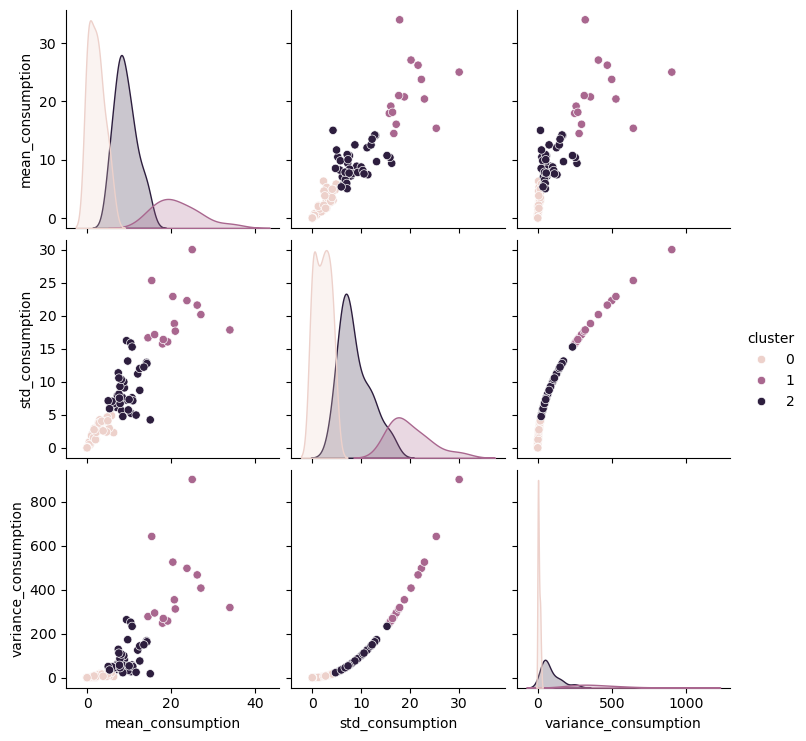

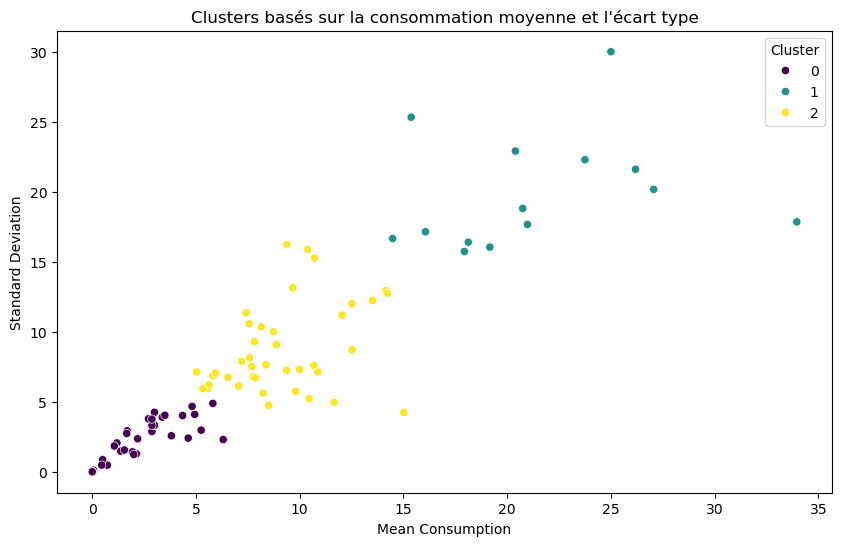

Cluster 0: Utilisateurs [1, 3, 4, 6, 7, 8, 11, 13, 17, 22, 23, 28, 29, 35, 37, 39, 42, 43, 45, 48, 51, 54, 55, 56, 60, 61, 67, 69, 70, 74, 75, 76, 78, 82, 83, 84, 87, 89]
Cluster 1: Utilisateurs [2, 14, 16, 24, 34, 38, 44, 47, 50, 63, 65, 66, 85, 86]
Cluster 2: Utilisateurs [5, 9, 10, 12, 15, 18, 19, 20, 21, 25, 26, 27, 30, 31, 32, 33, 36, 40, 41, 46, 49, 52, 53, 57, 58, 59, 62, 64, 68, 71, 72, 73, 77, 79, 80, 81, 88, 90, 91, 92]


In [10]:
# Bibliothèques nécessaires
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Vérifier les doublons et les supprimer (si nécessaire)
user_features_sliding = user_features_sliding.drop_duplicates(subset=['user_number'])

# Normaliser les colonnes pertinentes pour le clustering
scaler = StandardScaler()
features_normalized = scaler.fit_transform(
    user_features_sliding[['mean_consumption', 'std_consumption', 'variance_consumption']]
)

# Appliquer KMeans avec k=3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_features_sliding['cluster'] = kmeans.fit_predict(features_normalized)

# Vérifier l'affectation des clusters
print(user_features_sliding[['user_number', 'cluster']].drop_duplicates())
# Appliquer le clustering KMeans
user_features_sliding['cluster'] = kmeans.fit_predict(features_normalized)

# Vérifier combien d'utilisateurs sont affectés à chaque cluster
cluster_counts = user_features_sliding['cluster'].value_counts()
print(f"Répartition des utilisateurs par cluster:\n{cluster_counts}")

# Visualisation des clusters avec seaborn pairplot pour observer les relations entre les variables
sns.pairplot(user_features_sliding, hue='cluster', diag_kind='kde', 
             vars=['mean_consumption', 'std_consumption', 'variance_consumption'])
plt.show()

# Visualisation des clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=user_features_sliding['mean_consumption'],
    y=user_features_sliding['std_consumption'],
    hue=user_features_sliding['cluster'],
    palette='viridis'
)
plt.title('Clusters basés sur la consommation moyenne et l\'écart type')
plt.xlabel('Mean Consumption')
plt.ylabel('Standard Deviation')
plt.legend(title='Cluster')
plt.show()

# Liste des utilisateurs dans chaque cluster
clusters_users = (
    user_features_sliding.groupby('cluster')['user_number']
    .apply(list)
    .to_dict()
)

# Affichage des utilisateurs par cluster
for cluster_id, users in clusters_users.items():
    print(f"Cluster {cluster_id}: Utilisateurs {users}")

In [11]:
# Assurer que les doublons sont supprimés dans user_features_sliding pour éviter les erreurs
user_features_sliding = user_features_sliding.drop_duplicates(subset=['user_number'])

# Fusionner les informations de cluster avec df basé sur le user_number
df_with_clusters = df.merge(user_features_sliding[['user_number', 'cluster']], on='user_number', how='left')


In [12]:
df_with_clusters

,user_number,datetime,Consommation,cluster
0,1,2016-03-01 01:19:43,0,0
1,1,2016-03-01 02:19:43,0,0
2,1,2016-03-01 03:19:43,0,0
3,1,2016-03-01 04:19:43,0,0
4,1,2016-03-01 05:39:54,0,0
...,...,...,...,...
673922,92,2017-02-28 18:08:01,0,2
673923,92,2017-02-28 19:08:06,0,2
673924,92,2017-02-28 20:08:06,27,2
673925,92,2017-02-28 21:08:06,43,2


In [13]:
# Sauvegarder le DataFrame résultant avec les clusters
df_with_clusters.to_csv("df_with_clusters.csv", index=False)
